In [1]:
# general imports usually needed
import numpy as np
import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd

In [2]:
# libraries more specific to this lecture notebook
import os.path
import sys
sys.path.append('../../src')
from ml_python_class.config import DATA_DIR

from sklearn.linear_model import LinearRegression

In [3]:
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [4]:
# notebook wide settings to make plots more readable and visually better to understand
np.set_printoptions(suppress=True)

#%matplotlib widget
#%matplotlib inline
%matplotlib ipympl

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('figure', titlesize=18)
plt.rc('legend', fontsize=14)
plt.rcParams['figure.figsize'] = (12.0, 8.0) # default figure size if not specified in plot
plt.style.use('seaborn-v0_8-darkgrid')

# 4. (Chapter 4) Training Models

In this chapter we will begin our study of Machine Learning algorithms in earnest.  Up
to this point you have gotten a taste of using some ML models as black boxes.
You don't really know internally what they are doing or how they work.  But still, learning
the API of how to create data sets and set up models for training, and knowning in
general what supervisied learning is and how you train a model to fit a dataset is
sufficient to start working with ML.

However, at some point you will be working with a dataset and you will get some
weird or unexpected results.  Also there are myriads of parameters and hyper-parameters,
not to mention issues with formatting and cleaning your data, and tweaking
training procedures, etc. that will all always be a bit mysterious and/or you will only
learn by wrote checklists, if you don't understand some of the fundamentals of the
internal implemenations of the various ML algorithms you use.

Understanding whats under the hood will help you quickly understand what types of ML
models will be promising or not for the data you have.  It will give you an understanding
of the hyper-parameters the model uses, and what you might want to try for these parameters
to get good results.  Understanding whats under the hood will also allow you to debug
and spot issues you have with training and debugging your models.  It will allow you
to perform error analysis, and better understand why your models may be working, and why
they may be failing, so that you can tweak things to improve their performance.

In short, while you can be a push-button/check-list using data analyst, if you eventually
want to improve your skills and become a better data scientist, you need to start
learning the internal working of ML algorithms.  Our goal in this class is to begin
your journey along this path.  We won't become experts on any of the ML methods we 
will look at, but we hope to introduce you to the fundamental concepts and inner
workings, so that you can beging to understand more deeply how the techniques work.

In this chapter, and units of our course, we will begin by looking at **linear regression**
(which we have used already), followed by **logistic regression**.  These units are very
important, as these models have basic concepts that are often similar across many types
of ML algorithms.  We will look at the idea of the **cost function** (or **fitness function**),
and how this can be used with techniques like **gradient descent** to fit the parameters
of a model in general to make predictions about a set of data.  Linear regression
is a technique for performing regression modeling (predict real valued outputs), while
logistic regression is useful for classification (despite its name, which is a bit
misleading at best).  By comparing similarities and differences of cost functions and
fitting models between regression and classification tasks, we will illustrate some general
principles of ML that apply to many types of supervisied learning models, whether
regression or classification tasks.

In [5]:
# load data into pandas dataframe
house = pd.read_csv('../../data/housing-prices-portland-or.csv')
house.drop('bedrooms', axis=1, inplace=True) # we are not using bedrooms attribute in this example
house.price = house.price / 1000.0 # specify house price in 1000s $

# use x and y for convenience
y = house.price.values
x = house.sqft.values

## 4.2 Gradient Descent

**Gradient descent** is a very generic optimization algorithm capable of finding optimal
solutions to a wide range of problems.  The general idea of gradient descent is to
tweak parameters iteratively in order to follow a gradient down to a minimum
of a cost function.



### Cost Function Intuition

Lets try and build an intuitive understanding of the shape of the MSE
cost function we are currently focusing on.

Lets ignore the intercept parameter and assume our linear function goes
through the origin at the $y = 0$ for the intercept.  In such a case
we only need to fit the single paramter $\theta_1$ or the slope.

Further lets use points generated with a slope of 1 with no noise.  For example.

In [6]:
# 4 points on the line y = 0 + 1 x
X = np.array([[0],
              [1], 
              [2], 
              [3]])
y = np.array([[0, 1, 2, 3]])

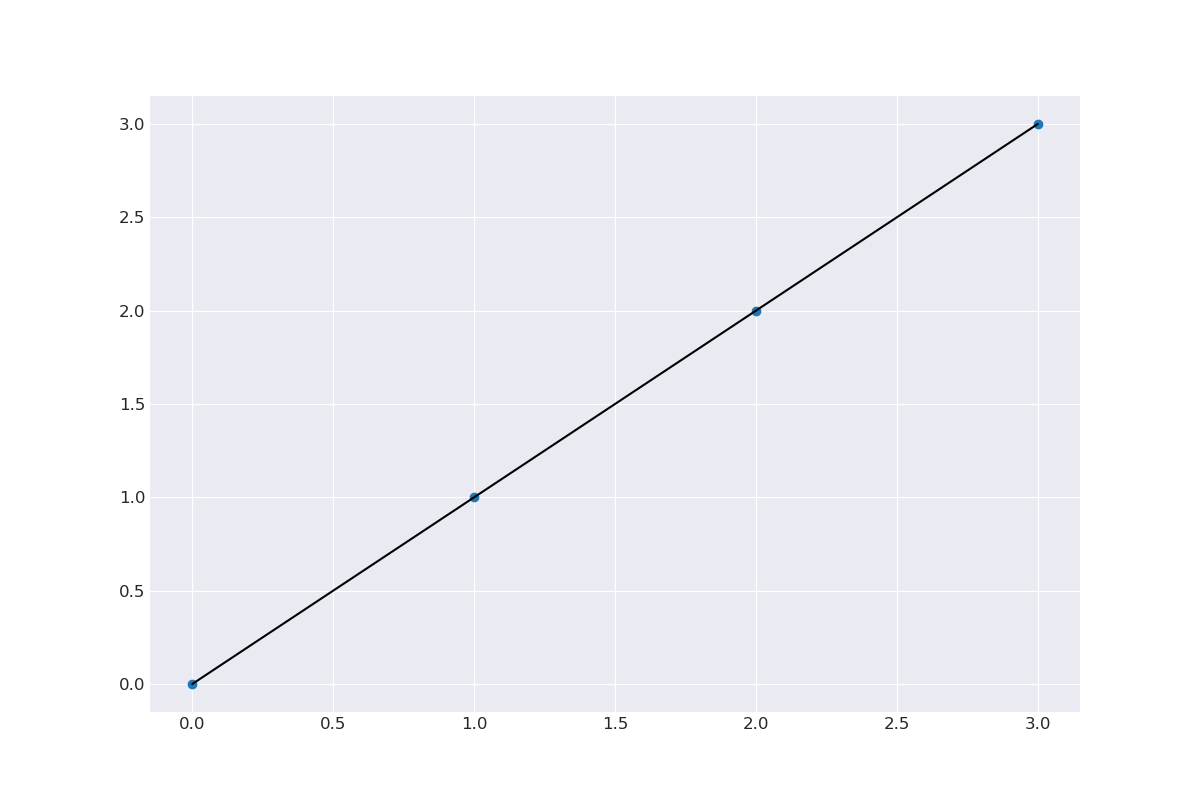

In [7]:
fig = plt.figure()

# just to be clear, the plot of these 3 points which have a slope of 1 and
# an intercept of 0
plt.scatter(X, y)

# plot the line from x=0 to x=3 with slope 1 and intercept 0
plt.plot(X.flatten(), y.flatten(), 'k-');

In [8]:
def cost_function_MSE(theta_1, X, y):
    """Given the theta_1 slope parameter, and a set of x features and the
    y targets, compute and return the MSE for the given parameter of 
    theta_1.
    
    Parameters
    ----------
    theta_1 - A NumPy array of theta_1 values to calculate cost of, which
        are the theta_1 or slope parameter for a
        hypothesis function h_{theta_1}
    X - A NumPy array of values to compute the MSE of, expected to be 
        a column matrix with each attribute/feature in a column, and
        m = number of samples = number of rows
    y - A NumPy array of values that are the true labels or target
        that our hypothesis function tries to predict.  Expected to
        be a vector of size (m,)
        
    Returns
    -------
    mse - Returns the means of the sume of the squared errors for the given theta_1
        parameter and our x inputs and y targets/labels
    """
    # get the number of samples and number of features
    m, n = X.shape
    
    # calculate predictions
    predictions = 0 + theta_1 @ X.T
    
    # calculate errors
    errors = predictions - y
    
    # calculate the sum squared error
    sse = np.sum(errors**2.0, axis=1)
    
    # calculate and return the mean of the sum squared errors
    mse = sse / m
    
    return mse

So for example, if our hypothesis funciton uses $\theta_1 = 1$ to predict, we
will get an error of 0, perfect predictions.

In [9]:
# make theta_1 an array, for reasons we will se in a moment
theta = np.array([1.0])
cost_function_MSE(theta, X, y)

array([0.])

But of course for $\theta_1$ not equal to 1, there will be some error, and the
further from the correct slope of 1, the more the error.

In [10]:
theta = np.array([1.1])
cost_function_MSE(theta, X, y)

array([0.035])

In [11]:
theta = np.array([0.5])
cost_function_MSE(theta, X, y)

array([0.875])

In [12]:
theta = np.array([2.0])
cost_function_MSE(theta, X, y)

array([3.5])

Our function is vectorized, so we can actually pass in a range of $\theta_1$
values to the cost function, e.g.

In [13]:
theta = np.linspace(-1.0, 3.0, 7).reshape((7,1))
theta

array([[-1.        ],
       [-0.33333333],
       [ 0.33333333],
       [ 1.        ],
       [ 1.66666667],
       [ 2.33333333],
       [ 3.        ]])

And we will get back the 7 computed costs for each of the given candidate
values of $\theta_1$.

In [14]:
mse = cost_function_MSE(theta, X, y)
mse

array([14.        ,  6.22222222,  1.55555556,  0.        ,  1.55555556,
        6.22222222, 14.        ])

This allows us to treat the cost function as a function of theta, that
takes theta as input and maps it to the associated cost.  If we plot the
cost function over a range of values, we see the following.

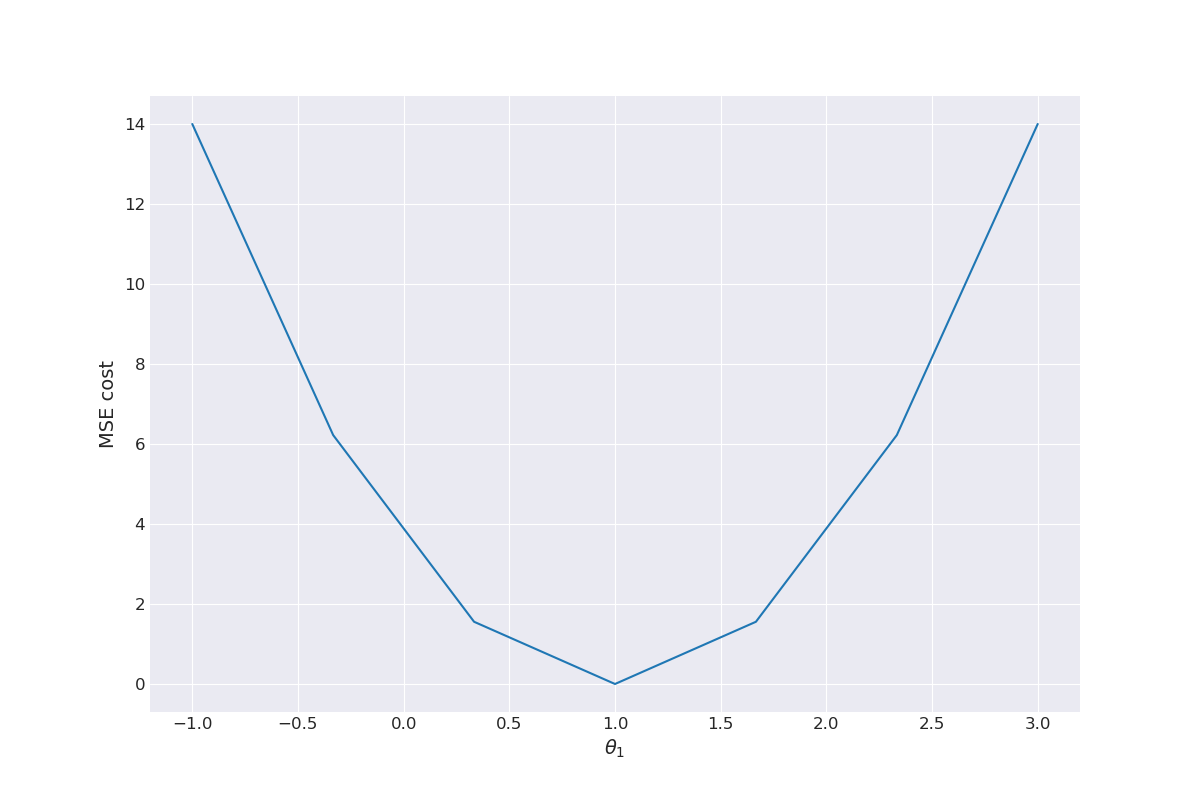

In [15]:
fig = plt.figure()

plt.plot(theta, mse);
plt.xlabel(r'$\theta_1$')
plt.ylabel('MSE cost');

The function is not actually so discontinuous.  In fact it is a smooth continuous
function, because it is a quadratic function, so it is essentially
a parabola.  We can see the true smooth shape if we increase our grid resolution.

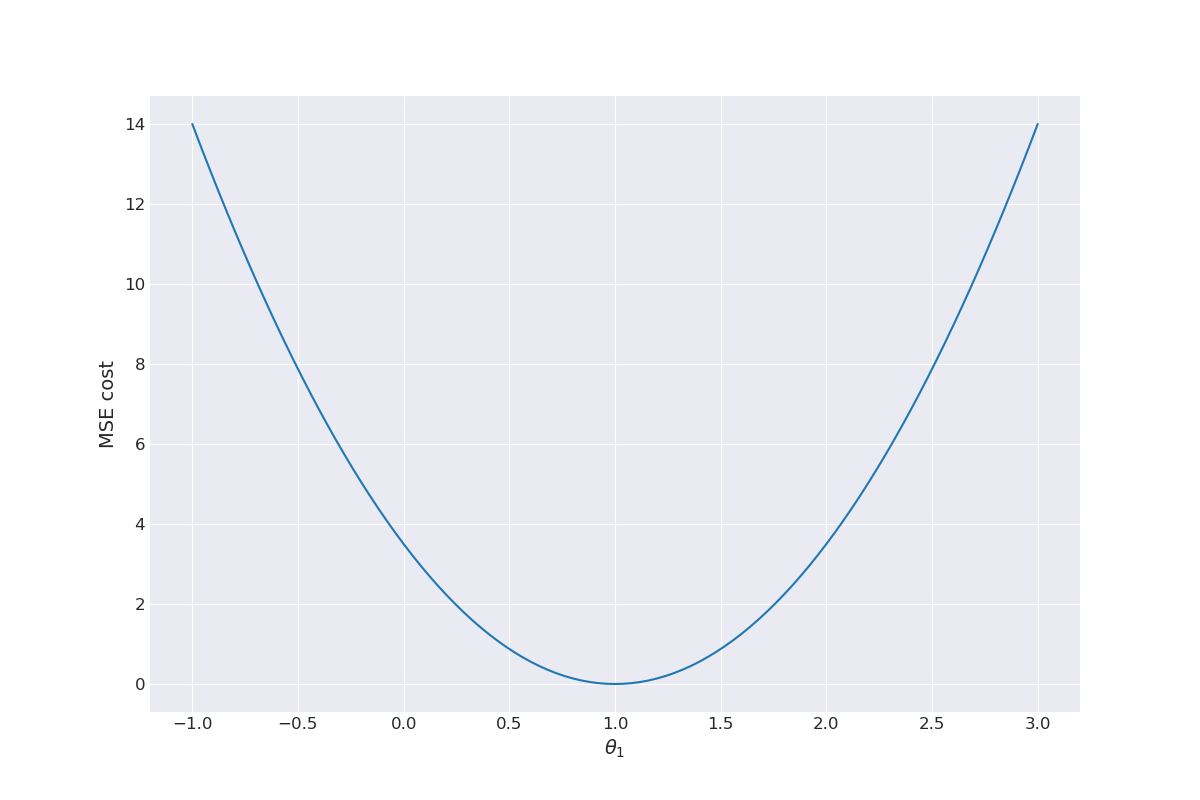

In [16]:
fig = plt.figure()

theta = np.linspace(-1.0, 3.0, 101).reshape((101,1))
mse = cost_function_MSE(theta, X, y)
plt.plot(theta, mse);
plt.xlabel(r'$\theta_1$')
plt.ylabel('MSE cost');

All of the MSE cost function look like this, though they usually won't
reach all of the way to 0 since usually a perfect fit of the data
is not possible.  They are shaped as a parabola in 2 dimensions because
a quadratic (square) function, which is what we do to calculate the error for this
cost function, results in such a parabola.  If we add back in $\theta_0$
we will need a 3 dimensional plot to visualize the resulting shape, which
will be a bowl, but there will still be only a single global minimum of the cost
function.  For example, still using our line with slope of 1 and intercept
of 0, the cost function using a contour plot looks like this.

In [17]:
def cost_function_MSE(Theta, X, y):
    """Fix our previous function to work in general case.  Now Theta can
    be an array of 2 or more parameters of theta, where each column is a
    different hypothesis to evaluate.  We expect Theta[0] (row 0) to 
    be the bias or intercept term, and Theta[1]  (row 1) and greater the remaining
    parameters.  We also now expect that the bias attribute is added to the
    X inputs before calling this function.
    
    Parameters
    ----------
    Theta - A NumPy array of 1 or more Theta hypothesis.  The shape 
        needs to be (n, t) where we have 1 row for each feature
        (column) of the inputs x.  We can have 1,2 or t rows to calculate
        the cost of 1, 2 ... t different hypothesis simultaneously.
    X - A NumPy array of values to compute the MSE of, expected to be 
        a matrix in normal form we expect of shape (m,n) where there 
        are m samples in the rows and n feature columns.  We need to
        transpose this matrix into columns holding the samples to match
        the normal way vector/matrix equations are specified.
    y - A NumPy array of values that are the true labels or target
        that our hypothesis function tries to predict.  Expected to
        be a vector of shape (m,)
        
    Returns
    -------
    mse - Returns the means of the sum of the squared errors for the given Theta
        parameters and our X inputs and y targets/labels
    """
    # get the number of samples and number of features
    m, n = X.shape
    
    # calculate predictions, result is a (t,m) shaped array of a set of
    # predictions for each of the m samples, one row for each of the
    # Theta predictions being calculated
    predictions = Theta.T @ X.T # X needs to be made into column matrix
    
    # calculate errors, resulting shape is still (t,m), the y target will be
    # subtracted from each row by broadcasting
    errors = predictions - y.reshape(1,-1)
    
    # calculate the sum squared error, only along axis 0 so we sum the rows.
    # result is (t,1) shaped
    sse = np.sum(errors**2.0, axis=1)
    
    # calculate and return the mean of the sum squared errors
    mse = sse / m
    
    return mse

In [18]:
# 3 points on the line y = 1 + 1 x
X = np.array([[0],
              [1], 
              [2], 
              [3]])
y = np.array([1, 2, 3, 4])

In [19]:
# we will create a 2D grid of theta_0, theta_1 pairs to evaluate
# range theta_0 from -2 to 2
grid_size = 101
#theta_0 = np.linspace(-1, 1, grid_size)
theta_0 = np.linspace(0, 2, grid_size)

# range theta_1 from -1 to 3 like we did before
#theta_1 = np.linspace(-0, 2, grid_size)
theta_1 = np.linspace(0, 2, grid_size)

# create all combinations of theta_0 and theta_1 as a (grid_size^2, 2) shaped
# array, which is what our cost function will expect
Theta = np.array(np.meshgrid(theta_0, theta_1)).reshape(2, -1)
print(Theta.shape)

(2, 10201)


In [20]:
# need to add in bias attribute to X  for our updated cost function now
X_b = np.c_[np.ones((4,1)), X]

# calculate cost function over theta_0, theta_1 pairs
mse = cost_function_MSE(Theta, X_b, y)

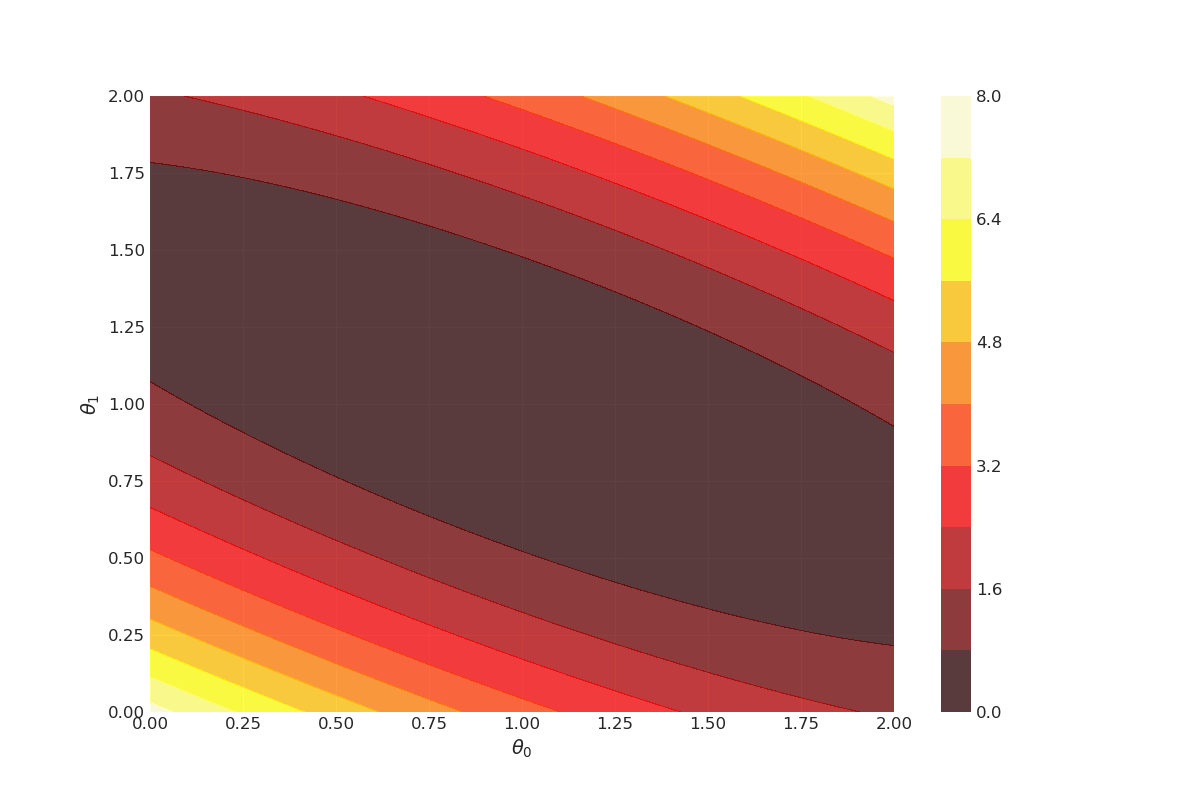

In [21]:
fig = plt.figure()

# contour expects X, Y and Z to all be 2d grids, so
Xp = Theta[0].reshape((grid_size, grid_size))
Yp = Theta[1].reshape((grid_size, grid_size))
Zp = mse.reshape((grid_size, grid_size))

# plot the contours
contours = plt.contourf(Xp, Yp, Zp, 10, alpha=0.75, cmap=plt.cm.hot )
plt.colorbar()
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$');

The rate of change of the cost can be so fast that it is hard to see
details of how the cost function changes close to where it approaches
0 in this contour plot.

We can take the `log()` of the cost function, which will greatly reduce the
scale of the costs.  This is so we can mainly better visualize
the cost as we get close to the minum point.

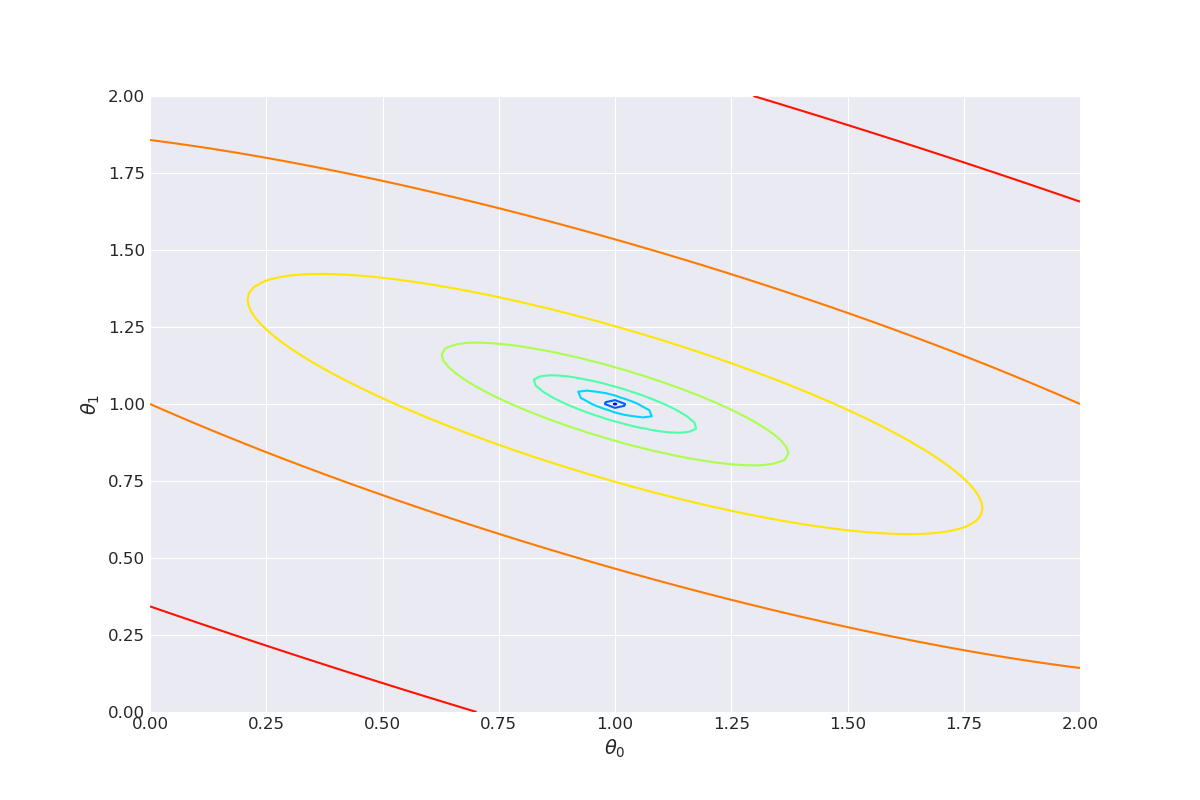

In [22]:
fig = plt.figure()

# plot the contours
#plt.contourf(Xp, Yp, np.log(Zp+0.0001), 10, alpha=0.75, cmap=plt.cm.cool)
#plt.colorbar()

coutours = plt.contour(Xp, Yp, np.log(Zp+0.0001), 10, cmap=plt.cm.jet)
#plt.clabel(contours, inline=1, fontsize=10);

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$');

We can also try and visualize the shape of the cost function in true 3
dimensions using a 3D plot.  It is helpful to install the needed extensions
and packages to allow for dynamic figures, and then to uncomment and use
the `%matplotlib widget` magic so that you can rotate and scale the 
3D plot to better get a sense of the shape of the cost function.

We have again plotted the `log()` of the cost values, to help with
visualizing how the cost is changing as it approches or moves away from
the minimum point.

In [23]:
#%matplotlib widget

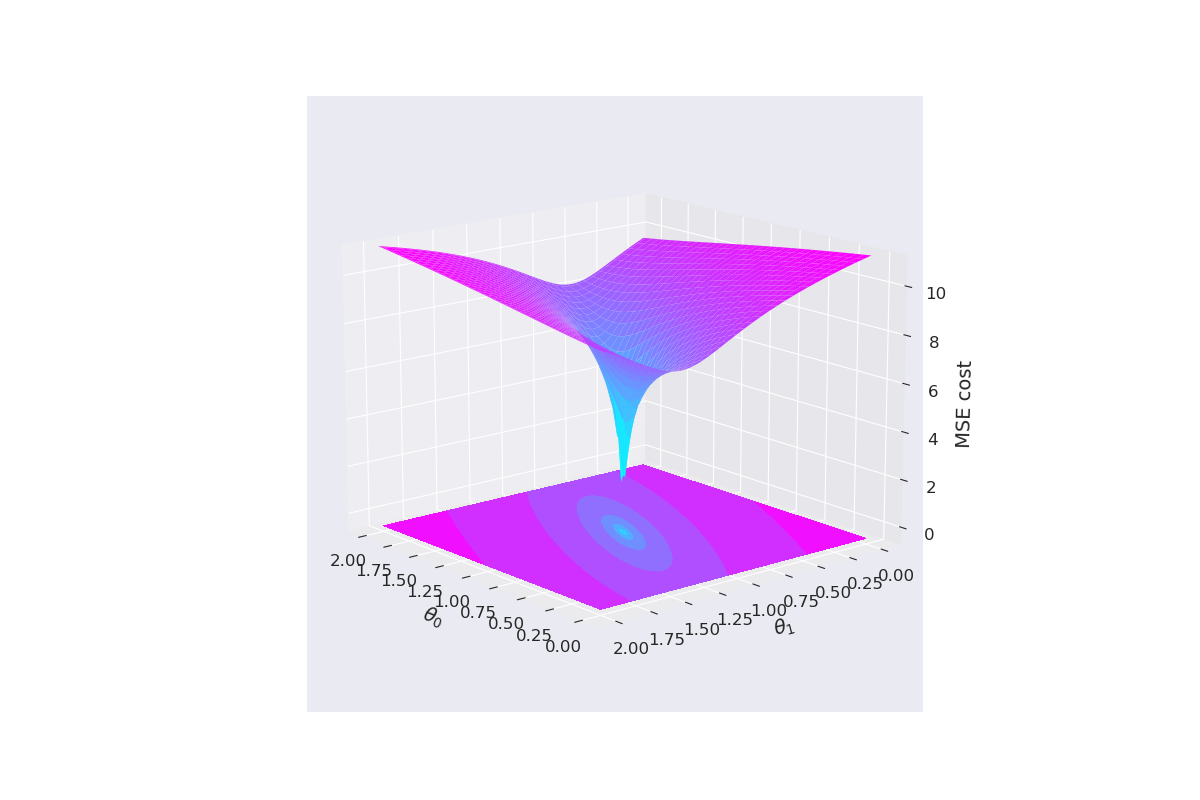

In [24]:
# need a special axes for 3D plotting
from mpl_toolkits.mplot3d import Axes3D

# create a figure object so we can add a 3D axes to it
fig = plt.figure()
#ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')

Zp_log = np.log(Zp + 0.0001)
Zp_log = Zp_log - Zp_log.min() + 0.0001
Zp_log_log = np.log(Zp_log)

ax.plot_surface(Xp, Yp, Zp_log, cmap=plt.cm.cool)
ax.contourf(Xp, Yp, Zp_log, zdir='z', offset=-0.5, cmap=plt.cm.cool);
ax.set_zlim([-0.5, 11.0]);
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_zlabel(r'MSE cost');

ax.view_init(15, 140)
#plt.show();

In [25]:
#%matplotlib inline

### Contour Plot Visualization

Lets now use the contour plot of the cost function with a representation
of a hypothesized line, to better visualize and understand the
relationship between a hypothesis $\theta = [\theta_0, \theta_1]$
and its calculated cost.

The next cell has a lot of code in it, but it basically recreats some 
previous figures side-by-side.  But given a hypothesis for 
$\theta$, we display both the hypothesized line, on the left, and
its location on the cost function, on the right.

We will also return to using our more realistic data example, fitting
a linear model of the price of houses given the size of the houses.
Recall that when we fit this data before, we found that the best
fitting line ends up with an intercept/bias term of $\theta_0 = 71.2$
and a slope feature term of $\theta_1 = 0.13$.


In [26]:
# recreate the X array with bias terms and y array for the house data
m, n = house.shape

# create array of 1s to initialize bias term, then set column 1 to be the
# size data
X = np.ones((m, n))
X[:,1] = house.sqft

# make sure y array has the house price targets
y = house.price.values

print(X.shape)
print(y.shape)

(47, 2)
(47,)


In [27]:
# create an appropriate grid of theta_0 and theta_1 for the contour plot
grid_size = 101
# theta_0 is the intercept term, the best fit intercept is at theta_0 = 71.2
theta_0 = np.linspace(-1000, 2000, grid_size)

# theta_1 is the slope term, the best fit slope is at theta_1 = 0.13
theta_1 = np.linspace(-0.5, 0.5, grid_size)

# create all combinations of theta_0 and theta_1 as a (grid_size^2, 2) shaped
# array, which is what our cost function will expect
Theta = np.array(np.meshgrid(theta_0, theta_1)).reshape(2, -1)
print(Theta.shape)

# calculate the cost over the grid
mse = cost_function_MSE(Theta, X, y)
rmse = np.sqrt(mse) # convert to the root mean squared error

# contour expects X, Y and Z to all be 2d grids, so
Xp = Theta[0].reshape((grid_size, grid_size))
Yp = Theta[1].reshape((grid_size, grid_size))
Zp = rmse.reshape((grid_size, grid_size))

(2, 10201)


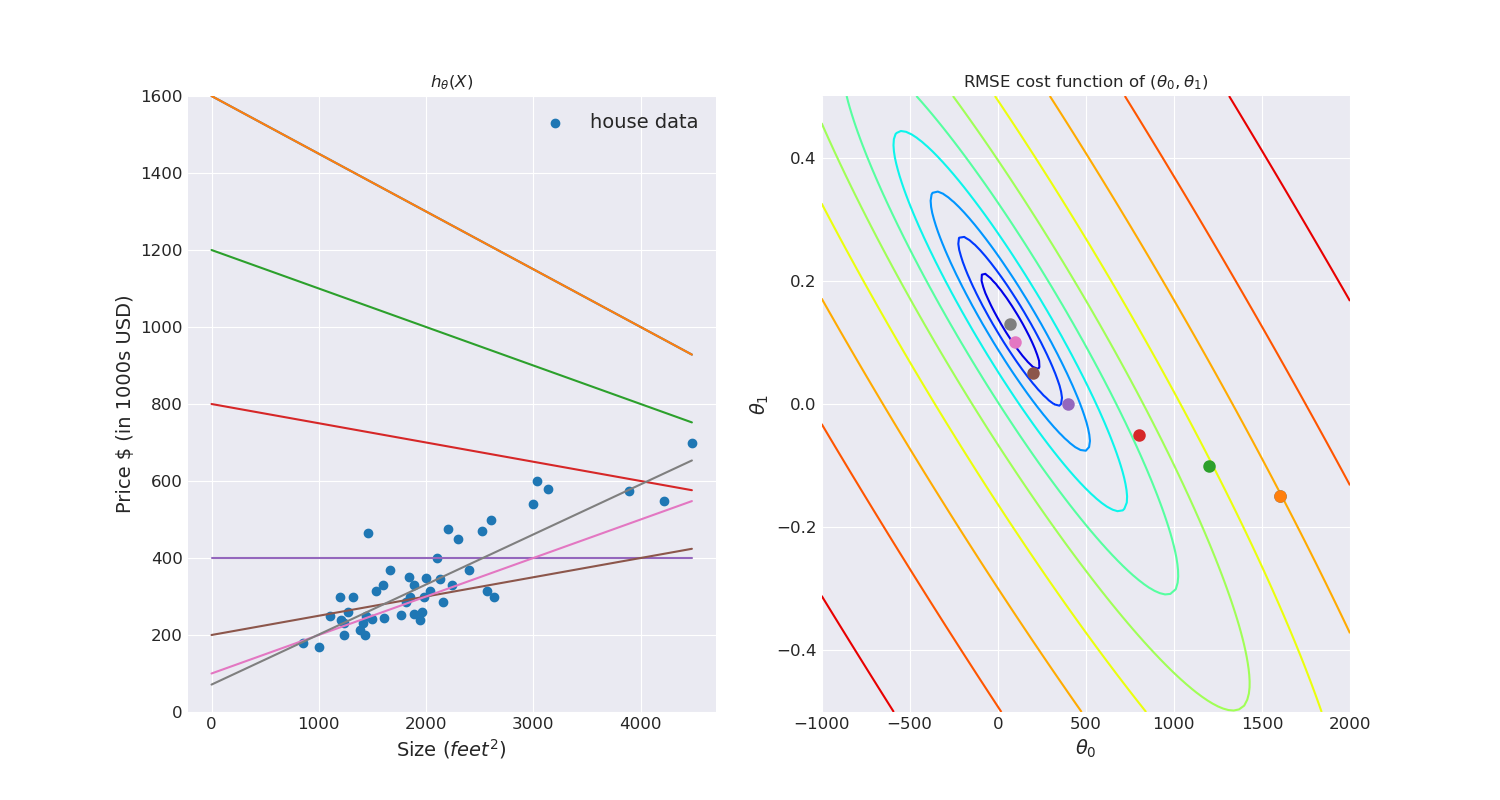

In [28]:
# create a figure for our 2 subplots, data and hypothes to left and 
# cost function contour plot on right
fig = plt.figure(figsize=(15,8))
plt.tight_layout()

# create left subplot, scatter plot of data with hypothesis
ax1 = plt.subplot(1, 2, 1)
plt.scatter(X[:,1], y, label='house data')
plt.xlabel(r'Size ($feet^2$)')
plt.ylabel('Price $ (in 1000s USD)')
plt.title(r'$h_{\theta}(X)$')
plt.ylim([0, 1600])
plt.legend();

# create right subplot, contour plot of the cost function
ax2 = plt.subplot(1, 2, 2)
contours = plt.contour(Xp, Yp, np.log10(Zp), 10, cmap=plt.cm.jet)
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
#contours.levels = [val**10.0 for val in contours.levels] # convert labels back to actual RMSE
#plt.clabel(contours, inline=1, fontsize=10)
plt.title(r'RMSE cost function of $(\theta_0, \theta_1)$');


# create an example sequence of Theta=(theta_0, theta_1) hypothesis

Theta = [(1600, -0.15),
         (1200, -0.1),
         (800,  -0.05),
         (400,   0.0),
         (200,   0.05),
         (100,   0.10),
         (71.2,  0.13)]
model_x = np.linspace(0, X[:,1].max(), 2)


def animate(i):
    (h_theta_0, h_theta_1) = Theta[i]
    hypothesis_y = h_theta_0 + h_theta_1 * model_x    
    
    lbl = r'hypothesis $\theta_0 = %0.2f \; \theta_1 = %0.2f$' % (h_theta_0, h_theta_1)
    line = ax1.plot(model_x, hypothesis_y, label=lbl)
    
    # visualize location of current hypothesis
    point = ax2.plot(h_theta_0, h_theta_1, 'o', ms=7.0, mew=2.0);
    return ((line, point), )

#for (h_theta_0, h_theta_1) in Theta:
#    hypothesis_y = h_theta_0 + h_theta_1 * model_x

ani = mpl.animation.FuncAnimation(fig, animate, frames=len(Theta), interval=1000)

from IPython.display import HTML
#HTML(ani.to_jshtml())
HTML(ani.to_html5_video())

Gradient descent algorithms work by starting with initial random values (or just 0) for all of the $\theta$ model parameters.
Then we measure the gradient (or slope) of the cost function at the current values of $\theta$, with respect to each
of the dimensions.  Then we take a small step down the gradient slope for each parameter.  The step size we take
at each iteration is an example of a **hyperparameter** of the gradient descen algorithm.  The step size is
often known as the **learning rate**.  If the learning rate is too small, then the algorithm will be slow to 
converge to the minimal cost.  But if the learning rate is too big, this can cause gradient descent to
diverge.

Gradient descent is an iterative algorithm, in contrast to the normal equation, which is an analytic or exact
solution.  Exact solutions are preferable when they can be used, but there are many situations where the
normal equation will not work to find the minimal cost solution.  We have already discussed
computational complexity issues.  When the number of features of the data set becomes very large, 
exact solutions can take a very long time to compute relative to using an iterative gradient descent.
Also, not all cost functions are as well behaved as the RMSE cost we have been using as an example
so far.  The RMSE cost function is a convex function, and it only has a single global minimum
value.  So an exact solution like the normal equation is guaranteed to find the
one and only solution in that case.  

But as discussed in our textbook for Figure 4-6,
more complex cost functions do not always have these properties.  Cost functions can be
non-convex, meaning there can be more than 1 minimum point
for the cost function.  More complex cost functions can be much tougher, if not impossible, 
to solve with an analytic solution, thus requiring a minimization technique
like gradient descent to be applied.

But we do have to keep in mind these difficulties when using gradient descent.  If there are
multiple minimum points, the gradient descent will only return a single one of these for each random
starting point we begin iterating from.  The minimum we converge on may only be a local minimum, and
other much better solutions could exists elsewhere in the parameter landscape.  Also some features of
the cost function can cause issues for convergence.  Our textbook gives an example of plateaus of 
the cost function.  If our gradient descent is changing slowly, we may be at a minimum point, or we may be at
a plateau that, if we just iterate longer, we would eventually pass over to find a steeper gradient.  But it
is impossible to determine which of these might be the case just from examing the local gradient
of our cost function.  As discussed briefly, one reason that scaling features to have similar scales
can be important is that it tends to remove or lessen such plateaus in the cost function,
making gradient descent iteration more likely to run smoothly.

### Batch Gradient Descent

To implement gradient descent you need to be able to compute the gradient of the cost function with regards to each of the model
paramters $\theta_j$, which we have not mentioned up to this point.

We can give a precise meaning to this, in fact the gradient is simply the slope of the function at that point, which can be found by computing
the derivative of the function.  In this case it is technically what is known as the *partial derivative* of the function, because we want
to compute it with respect to each of the $\theta_j$ parameter dimensions of our cost function.

Getting the gradient of our cost function will of course depend on what cost function is being used.  For example, for the MSE function, which is
essentially a quadratic function (albeit using linear algebra vectors and matrices), it is relatively straight forward to derive an analytic expression
that can compute the derivatives of the cost function with respect to the model parameters.

$$
\frac{\partial}{\partial \theta_j} \text{MSE}(\theta) = \frac{2}{m} \sum_{i=0}^{m-1} \big( \theta^T x^{(i)} - y^{(i)} \big) x_j^{(i)}
$$

The symbol $\frac{\partial}{\partial \theta_j}$ is simply the symbol for the partial derivative.  It has a meaning to the symbol for the derivative
of a function $\frac{d}{dx}$.  And while deriving the derivative of the MSE cost function is beyond the scope of the class here, you
should notice, if you are familiar with basic calculus and taking derivatives, that the square term of the error has been derived using
the basic power rule, e.g. $\frac{d}{dx} x^2 = 2 x ^{2-1} = 2x$, and then also a chain rule is applied so that we multiply this
by the paramter we are deriving with respect to $x_j^{(i)}$.  Notice that we change the index of the summation to $0..(m-1)$ as we did before
for our 0-based NumPy indexing.  The summation is necessayr here because we want the gradient with respect to all $m$ of the input
samples, not just the gradient of the single $i^{th}$ sample.  So we are in essense calculating and averaging over the gradients for all of 
the $m$ samples of our training data set here.  When we compute the gradient over all of the input samples, this is known as
batch gradient descent, as opposed to stochastic or mini-batches, which compute the gradient for only a single or a few of the
samples at a time (covered next).

You can use the above formula to compute the necessary gradients, and thus implement gradient descent with the MSE cost function.
However, we can further vectorize the summation, making the computation of the gradients even more efficient in NumPy.
The gradient vector, shown here, is a fector of the gradients of each of the $\theta_j$ paramters, and can be computed
with a relatively simple set of matrix multiplications:

$$
\nabla_{\theta} \text{MSE}(\theta) = 
\begin{pmatrix}
\frac{\partial}{\partial \theta_0} \text{MSE}(\theta) \\
\frac{\partial}{\partial \theta_1} \text{MSE}(\theta) \\
\vdots \\
\frac{\partial}{\partial \theta_n} \text{MSE}(\theta) \\
\end{pmatrix}
= \frac{2}{m} X^T (X \theta - y)
$$

And while this looks complex, the $\nabla_{\theta}$ is simply a symbol meaning that the result is a vector of the gradients.  And as
you can see, the vector is basically what we would get if we computed each individual gradiant with respect to $\theta_0, \theta_1, \cdots \theta_n$
and put the resulting gradients into a vector.  In sort, the relatively simple matrix multiplication shown will compute the gradient
vector of the gradients with respect to each of our features, in a single statement for all of the $m$ samples in our
training data.

Again notice that this formula involves calculations over the full training set $X$, at each gradient descent step.  A better name for
this algorithm might be *full gradient descent* since it is calculated fully over all of the input samples $X$.  But it is
actually known as *batch gradient descent* meaning that the full batch of inputs $X$ are used for each descent step.

Once you have the gradient vector, which points uphill, we can just go in the opposite direction for each of the parameter
dimensions $\theta_j$ to go down hill.  This means subtracting the gradient vector $\nabla_{\theta} \text{MSE}(\theta)$ from
$\theta$.  This is where the learning rate hyperparameter comes in.  We will use the symbol $\eta$ for our learning
rate, and multiply the gradient by the learning rate to determine the size of our downhill step.

$$
\theta^{(\text{next step})} = \theta - \eta \nabla_{\theta} \text{MSE}(\theta)
$$

Putting this all together, we can create vectorized functions for our MSE cost function, gradients, and batch gradient descent relatively
easily.

Lets start by using randomly generated data again with an intercept/bias term
of 4 and a slope of 3.  Notice that if we calculate the cost for a hypothesis
with this intercept and slope we no longer get a cost of 0 since we added
noise into the data.  But the cost at the actual slope and intercept used to generate
the data should be close to the minimal cost we will be able to achieve.  Likewise,
if we calculate the gradients at these points, they should be close to 0, but
probably not exactly 0 because of the noise that was added.

In [29]:
# use random data for first example like before, with a slope of 3 and 
# intercept of 4
x = 2.0 * np.random.rand(100, 1)
y = 4.0 + 3.0 * x
y = y + np.random.randn(100, 1)

# create matrix adding in bias feature
X = np.ones( (100, 2) )
X[:,1] = x.flatten()

print(X.shape)
print(y.shape)

(100, 2)
(100, 1)


In [30]:
# test cost, each hypothesis is in a column, where row 0 is the intercept
# and row 1 is the slope.  Column 3 is hypothesis that matches the random
# data we generated, though because of noise the cost will not be 0
# anymore, but should probably be close to the minimal cost we can expect
# to achieve
Theta = np.array([
    [0.0, 1.0, 4.0],
    [0.0, 1.0, 3.0], 
])

cost_function_MSE(Theta, X, y.reshape(1,-1))

array([55.13613543, 28.66086738,  0.96215778])

In [31]:
Theta = np.array([
    [4.0],
    [3.0], 
])

cost_function_MSE(Theta, X, y.reshape(1,-1))

array([0.96215778])

In [32]:
def gradient_function_MSE(Theta, X, y):
    """Theta is an array of 2 or more parameters of theta.  We expect Theta[0]
    (row 0) to  be the bias or intercept term, and Theta[1] (row 1) and
    greater the remaining parameters.  We also now expect that the bias
    attribute is added to the X inputs before calling this function.  We
    expect X in normal shape (m,n) with m rows representing the samples, and 
    n feature columns.  The number of columns n here needs to match the number
    of rows of Theta and number of targets in the outputs y.  Since X is
    arranged with samples along the rows, but mathematical notation
    expects each column to have a sample, have to transpose X before using.
    
    This function computes the gradients of the MSE cost function for the
    inputs X with respect to the target outputs y, at the given current
    model paramter settings Theta.  This function returns the
    gradient vector, a vector of n gradients with respect to each of the
    model paramters Theta[j]
    
    Parameters
    ----------
    Theta - A NumPy array of 1 or more Theta hypothesis.  The shape 
        needs to be (n, t) where we have 1 row for each feature.
        You can multiple columns, one for each potential
        hypothesis function to test, or a single column.
    X - A NumPy array of values to compute the gradients of, expected to be 
        a matrix shaped (m, n) in the normal way with m rows holding
        the samples, and n feature columns.  This is transpose of how
        mathemetical equations are specified, so we take transpose of X
        before using in our calculations.
    y - A NumPy array of values that are the true labels or target
        that our hypothesis function tries to predict.  Expected to
        be a vector of size (m,)
        
    Returns
    -------
    gradient vector - returns a vector or n gradients, one with respect to
        each of the n model paramters of Theat.
    """
    # get the number of samples m and number of features n
    m, n = X.shape
    
    # calculate predictions, result is a (t,m) shaped array of a set of
    # predictions for each of the m samples, one row for each of the 
    # Theta predictions being generated
    predictions = Theta.T @ X.T # X needs to be made into column matrix
    
    # calculate errors, resulting shape is still (t,m), the y target will be
    # subtracted from each row by broadcasting
    errors = predictions - y.reshape(1,-1)
    
    # calculate gradients
    gradients = X.T @ errors.T
    
    # get gradient averages and return
    gradients = (2.0 / m) * gradients
    return gradients

In [33]:
print(gradient_function_MSE(Theta, X, y))

[[-0.2251434 ]
 [-0.14168888]]


Our implementation of the gradient calculations is similar to what the book
shows, though we do have to transpose a few things differently.  We need
to transpose the X input array for the initial caculations because the formula
you see in our text assume that X and y are column matrices/vectors, with samples
in each column instead of rows as we normally think of them.  

Given the gradients function, performing gradient descent is a simple
loop/iteration, where we calculate gradients and use them to calculate a 
step size based on the learning rate.  Most of the code in this function is 
actually to keep a history of the optimization, rather than the
actual work of calculating the gradients and update Theta for
each step.

In [34]:
def batch_gradient_descent(X, y, num_iter=1000, eta = 0.1):
    """This function performs batch gradient descent.  We iterate performing steps 
    down the gradient for some number of fixed iterations.  Theta
    is initialized to 0's initially by this function, and the minimal
    Theta achieved is returned, along with a hisory of the Theta values
    that were stepped through.  We are given the input samples X and the correct
    labels y we are to optimize for.
    
    Parameters
    ----------
    X - A NumPy array of input values to fit a linear model to using MSE cost
        function.  The array should be of size (m, n) where m = number of sample
        rows and n = number of feature columns
    y - A NumPy array of values that are the true lables or targets that we
        are fitting our linear function to.  Expected to be a vector of
        size (m,)
    num_iter - Number of gradient descent iterations to perform.  Defaults to 
        1000.
    eta - The learning rate to use for gradient descent steps, defaults to 0.1.
        
    Returns
    -------
    Theta - Returns the final best fit Theta parameter vectors
    history - A history of the Theta and gradients, returned as list of
        tuples (Theta, cost, gradients)
    """
    # get the number of samples m and number of features n
    m, n = X.shape
    
    # create random / 0 initial starting point for Theta
    Theta = np.zeros( (n, 1) )
    
    # keep and return history of gradient descent
    history = []
    
    # iterate down the gradient
    for iter in range(num_iter):
        # calculate current cost and the gradients w/respect to our current parameters
        cost = cost_function_MSE(Theta, X, y)
        gradients = gradient_function_MSE(Theta, X, y)
        
        # keep track of history of our gradient descent
        history.append( (Theta, cost, gradients) )
        #print('Itr %d: cost: %0.4f' % (iter, cost[0]))
        #print('    Theta: ')
        #print(Theta)
        
        # update 1 gradient descent step down the gradient according to the learning rate
        Theta = Theta - (eta * gradients)
        
    # return the final result
    return Theta, history

We can demonstrate how the batch gradient descent performs on the random data.
As shown in our textbook, try running the next few cells with different
values of the learning rate $\eta$.  A learning rate of 0.1 will converge, though
after only 10 iterations we are still pretty far from the optimal
fit (look at the final slope and intercept parameters).  You might need to
run more like 100 or 1000 iterations to get a slope closer to 3 and intercept
closer to 4.  But it converges much faster than say a learning rate of 0.02.
You should especially also try a larger learning rate, like $\eta = 0.5$.
You should observe in this case that the cost goes up, not down, and the
fitted lines get further and further away from the data.  This is an example
of divergence for the gradient descent algorithm.  When the learning rate is too
large, the next step will actually make the fit worse, not better, and when that
happens, successive steps will converge even further from the optimal
solution.

In [35]:
num_iter = 10
learning_rate = 0.1
Theta, history = batch_gradient_descent(X, y, num_iter=num_iter, eta=learning_rate)
print('Theta best fit: ')
print(Theta)

Theta best fit: 
[[3.42912139]
 [3.53343449]]


In [36]:
Theta_history = [h[0] for h in history]
cost_history = [h[1] for h in history]
gradient_history = [h[2] for h in history]

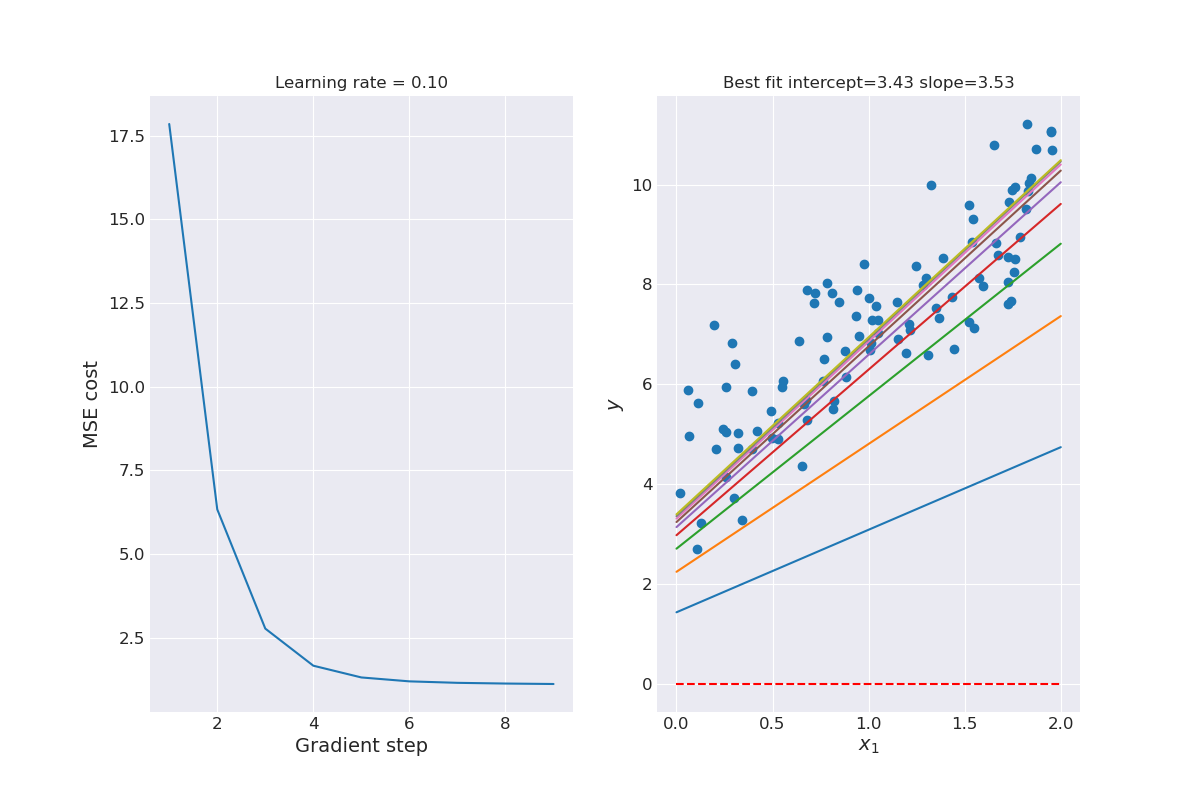

In [37]:
# visualize the resulting gradient descent
steps = np.arange(num_iter)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(steps[1:], cost_history[1:]) # omit first history to see slope better 
plt.xlabel('Gradient step')
plt.ylabel('MSE cost');
title='Learning rate = %0.2f' % learning_rate
plt.title(title);

plt.subplot(1,2,2)
plt.scatter(x, y);
theta_0, theta_1 = Theta_history[0]
x_h = np.linspace(0, 2, 2)
y_h = theta_0 + theta_1 * x_h
plt.plot(x_h, y_h, 'r--') # plot initial starting/random as red dashed line
for (theta_0, theta_1) in Theta_history[1:]:
    y_h = theta_0 + theta_1 * x_h
    plt.plot(x_h, y_h)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$y$')
title = 'Best fit intercept=%0.2f slope=%0.2f' % (Theta[0], Theta[1])
plt.title(title);

In the previous example we used a made up random data set.  If you try using the
batch gradient descent on, for example, our house price data, you may find that
it doesn't seem to work very well.  The learning_rate is way too high, so if you use
0.1 initially you will see that the gradient descent quickly diverges.  But
even for a learning rate that doesn't appear to diverge, you may find it difficult
to get the algorith to converge to the best fit, which recall
has a value of $\theta_0 = 71.27$ for the intercept and a value of $\theta_1 = 0.13$
for the slope.

In [38]:
# recreate the X array with bias terms and y array for the house data
m, n = house.shape

# create array of 1s to initialize bias term, then set column 1 to be the
# size data
X = np.ones((m, n))
X[:,1] = house.sqft

# make sure y array has the house price targets
y = house.price.values

print(X.shape)
print(y.shape)

(47, 2)
(47,)


In [39]:
num_iter = 100000
learning_rate = 0.0000002
Theta, history = batch_gradient_descent(X, y, num_iter=num_iter, eta=learning_rate)
print('Theta best fit: ')
print(Theta)

Theta best fit: 
[[0.38039765]
 [0.16521852]]


Even if you carefully find a learning rate that doesn't diverge and train for a long time,
it doesn't appear to get very close to the true optimal fit.

This is because of the different scale issue mentioned previously and by our textbook.
The house size has values in the range from 800 to 4500 square feet, which is a much
different scale than the bias parameter.  In order to successfully fit this data with
a gradient descent we have to rescale our parameter to be approximatly in the same range as
the bias parameter.

In [40]:
# just to get an idea of the current range
print(X[:,1].min(), X[:,1].max())

# shift all values so min becomes 0
orig_min = X[:,1].min()
X[:,1] = X[:,1] - orig_min

# rescale so all values in range 0 to 1
orig_max = X[:,1].max()
X[:,1] = X[:,1] / orig_max

print(X[:,1].min(), X[:,1].max())


852.0 4478.0
0.0 1.0


Now that we have rescaled to use min-max scaling, lets try again with
a 0.1 learning rate like we had been using as well.

In [41]:
num_iter = 1000
learning_rate = 0.1
Theta, history = batch_gradient_descent(X, y, num_iter=num_iter, eta=learning_rate)
print('Theta best fit: ')
print(Theta)

Theta best fit: 
[[185.91071917]
 [487.71409712]]


This doesn't look like the same intercept and slope, but this is the
value that converged for our data where we have scaled the 
house size x inputs to the range from 0 to 1. 

If we want to know what the slope and intercept are in our original
system, we have to recover the slope and intercept from these
values for our original unscaled data.  We can do this by
using the theta parameters we found to make predictions of 2
points, then unscale the x values back to our origanal
units.  And then finally, given the 2 points with our
x feature now unscaled, we can recover the slope and intercept
discovered on the scaled data.

In [42]:
# the slope and intercept we just found using gradient descent on
# the scaled x data
scaled_theta_0, scaled_theta_1 = Theta[:,0]
scaled_theta_0, scaled_theta_1

(185.91071916812388, 487.71409711687744)

In [43]:
# using our scaled slope and intercept, find 2 points on the prediction
# line this represents, using scaled x values of 0 and 1
x_1, y_1 = 0.0, scaled_theta_0 + scaled_theta_1 * 0.0
x_2, y_2 = 1.0, scaled_theta_0 + scaled_theta_1 * 1.0

print(x_1, y_1)
print(x_2, y_2)

0.0 185.91071916812388
1.0 673.6248162850013


In [44]:
# scale x values back to original range of house size in square feet
x_1 = (x_1 * orig_max) + orig_min
x_2 = (x_2 * orig_max) + orig_min

# we now have 2 points on the fitted line but where x is now 
# unscaled and back to the original units of square feet
print(x_1, y_1)
print(x_2, y_2)

852.0 185.91071916812388
4478.0 673.6248162850013


In [45]:
# determine equation of the line using these points, these are the
# actual theta parameters found on data before scaling x values
theta_1 = (y_2 - y_1) / (x_2 - x_1) # slope is change in y divided by change in x
theta_0 = y_1 - theta_1 * x_1 # from slope can determine intercept
print(theta_0, theta_1)

71.31270186432367 0.1345047151453054


So at the end you should see that the gradient descent did in fact
converge on the correct solution, though we have to recover
the slope and intercept for the original unscaled units after 
we converge to parameters in the scaled units.

.### Stochastic Gradient Descent

Batch (or full batch) gradient descent uses the whole training set to compute
the gradients at every step.  The gradients returned from above is an
average of the gradient for each dimension over all $m$ samples of the
training set.  If $m$ the number of samples is very large, this can make it
very slow to compute all of the gradients to take a step.  And if $m$ is truly
large, the data might not all fit into your computers memory, and thus it
would become impossible to perform a full batch gradient step if you
can't calculate the gradients for all samples since you can't have all
samples in memory at 1 time.

This leads to the idea of **stochastic gradient descent**
(**SGD**).  Stochastic here is just
a term that means random.  For stochastic gradient descent, instead of calculating
the gradient for all $m$ samples simultaneously, we instead select 1 sample
at random, calculate the gradients with respect to that single sample, and update
the $\theta$ parameters with regards to those gradienst.

This makes the alrogirhm faster, or at least we can update the theta paramters
by just calculating 1 single gradient rather gradients for all of the $m$
samples.  It also makes it possible to perform gradient descent for huge
data sets.  Even if not all inputs can fit into memory, we can calculate
steps using the samples we have in memory, then unload them and load other
data to calculate descent steps for these new samples.

But because of the random nature of selecting the next sample to optimze with at random, this algorithm is much less regular than batch gradient descent.  Instead
of gently decreasing until it reaches the minimum, the cost function will bounce
up and down, decreasing only on average.

Because of the more noisy nature of the resulting gradient descent, it becomes
much more essential to be a bit cleaverer with the learning rate.  In particular,
we might want to start with a large learning rate initially, but actually change
it and have it get smaller as training progresses.  This is an example of a
dynamic learning rate or **learning rate schedule**.  Usually we allow the
learning rate to vary, decreasing as a function of the number of iterations 
performed.

The simplest idea for SGD is to simply perform sumber number of epochs, where
each epoch we iterate $m$ times (the size of the samples).  But we pick
a single training item at random, calculate the gradients for this item,
and make our step based only on the single gradient.  Our functions for
calculating cost and gradients will work fine if we pass in a single
sample, so we can reuse those functions without change.

The following is the simplest example of SGD, though we do add in a learning
schedule function.  The learning sechdule function looks like this,
and it is a function of the epoch and the sample item index within
an epoch.

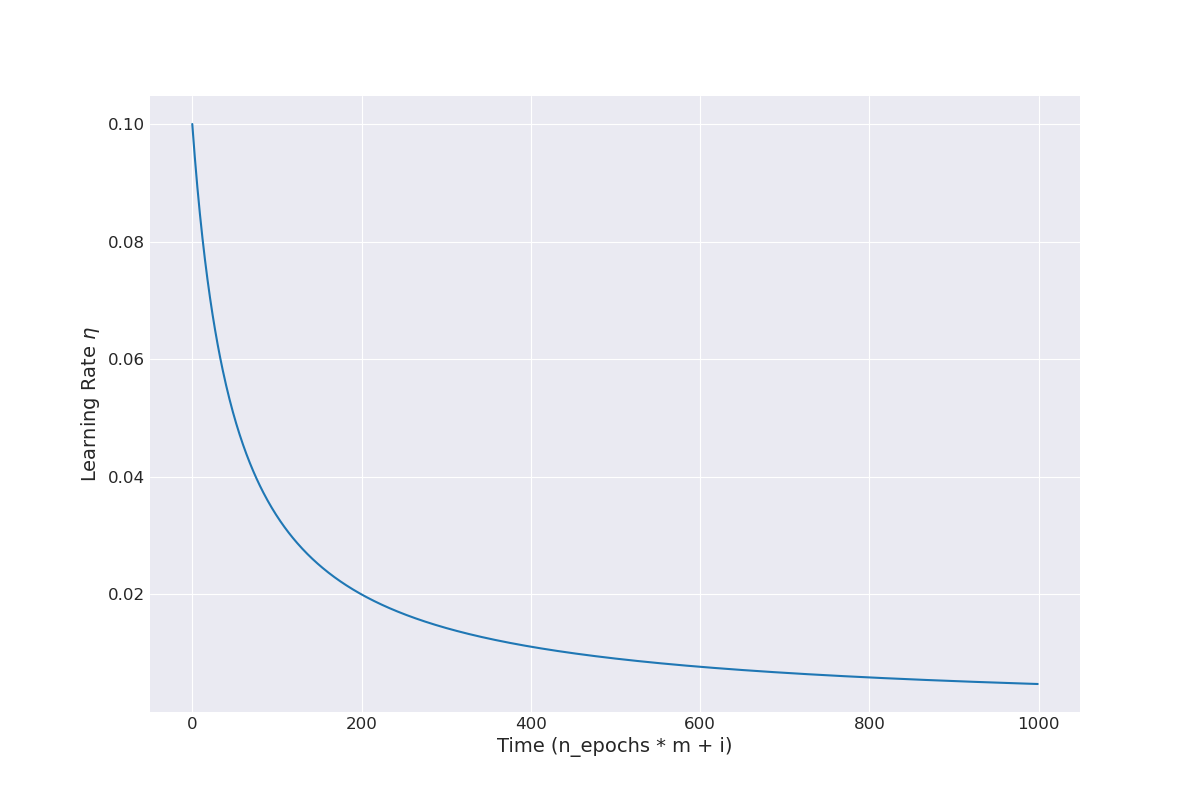

In [46]:
def learning_schedule(t):
    """The time t is just the epoch * m + i.  So it is really the total number
    of iterations performed so far.
    """
    # learning schedule hyperparameters, these could be turned into parameters of
    # this function if needed
    t0, t1 = 5, 50
    return t0 / (t + t1)

# show what the learning schedule function looks like
n_epochs = 10 # number of epochs we will perform
m = 100 # the number of samples m that we sample each epoch
t = np.arange(n_epochs * m)

fig = plt.figure()
plt.plot(t, learning_schedule(t))
plt.xlabel('Time (n_epochs * m + i)')
plt.ylabel(r'Learning Rate $\eta$');

In [47]:
def stochastic_gradient_descent(X, y, num_epochs=1000):
    """This function performs stochastic gradient descent.  We perform the
    indicated number of epochs.  During each epoch we iterate m times, where
    m is the number of samples in the training data X.  Theta
    is initialized to 0's initially by this function, and the minimal
    Theta achieved is returned, along with a hisory of the Theta values
    that were stepped through.  We are given the input samples X and the correct
    labels y we are to optimize for.
    
    Parameters
    ----------
    X - A NumPy array of input values to fit a linear model to using MSE cost
        function.  The array should be of size (m, n) where m = number of sample
        rows and n = number of feature columns
    y - A NumPy array of values that are the true lables or targets that we
        are fitting our linear function to.  Expected to be a vector of
        size (m,)
    num_epochs - Number of gradient descent epochs to perform.  During each
        epoch we perform m iterations where m is the number of samples in
        the input data X.
        
    Returns
    -------
    Theta - Returns the final best fit Theta parameter vectors
    history - A history of the Theta and gradients, returned as list of
        tuples (Theta, cost)
    """
    # get the number of samples m and number of features n
    m, n = X.shape
    
    # create random / 0 initial starting point for Theta
    Theta = np.zeros( (n, 1) )
    
    # keep and return history of gradient descent
    history = []
    
    # iterate down the gradient
    for epoch in range(num_epochs):
        # randomly sample an item m times for each epoch, using the randoly selected
        # item to perform a gradient step
        
        # we will keep history before start of each epoch
        cost = cost_function_MSE(Theta, X, y)
        
        # keep track of history of our gradient descent
        history.append( (Theta, cost) )
        #print('Epoch %d: cost: %0.4f' % (epoch, cost[0]))
        #print('    Theta: ')
        #print(Theta)

        for iter in range(m):
            # select an item at random, use slicing to extract the item
            random_index = np.random.randint(m)
            xi = X[random_index:random_index+1]
            yi = y[random_index:random_index+1]
            
            # calculate current cost and the gradients w/respect to our current parameters
            gradients = gradient_function_MSE(Theta, xi, yi)
            
            # calculate learning rate using schedule
            eta = learning_schedule(epoch * m + iter)
            
            # update 1 gradient descent step down the gradient according to the learning rate
            Theta = Theta - (eta * gradients)
        
        
    # return the final result
    return Theta, history

In [48]:
# use random data for first example like before, with a slope if 3 and 
# intercept of 4
x = 2.0 * np.random.rand(100, 1)
y = 4.0 + 3.0 * x
y = y + np.random.randn(100, 1)

# create matrix adding in bias feature
X = np.ones( (100, 2) )
X[:,1] = x.flatten()

print(X.shape)
print(y.shape)

(100, 2)
(100, 1)


In [49]:
num_epochs = 50
Theta, history = stochastic_gradient_descent(X, y, num_epochs=num_epochs)
print('Theta best fit: ')
print(Theta)

Theta best fit: 
[[4.16165153]
 [2.77707241]]


In [50]:
Theta_history = [h[0] for h in history]
cost_history = [h[1] for h in history]

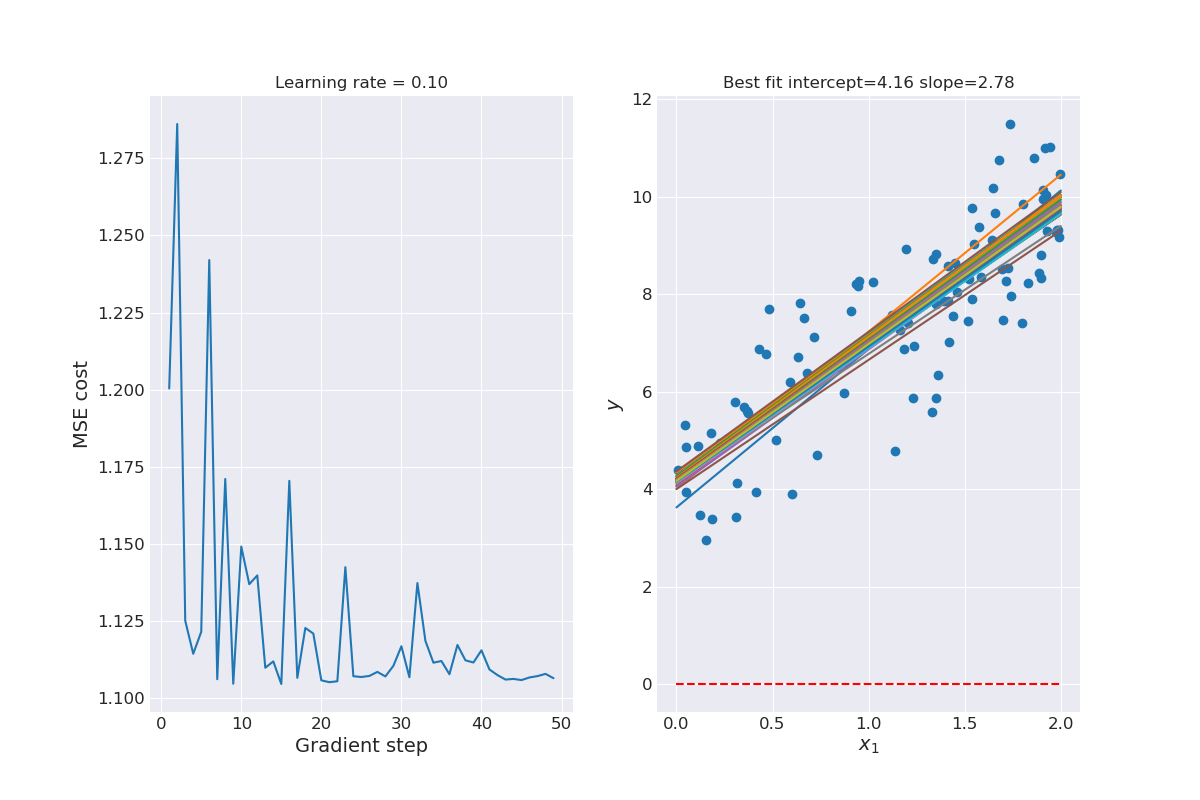

In [51]:
# visualize the resulting gradient descent
steps = np.arange(num_epochs)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(steps[1:], cost_history[1:]) # omit first epoch so can see cost better
plt.xlabel('Gradient step')
plt.ylabel('MSE cost');
title='Learning rate = %0.2f' % learning_rate
plt.title(title);

plt.subplot(1,2,2)
plt.scatter(x, y);
theta_0, theta_1 = Theta_history[0]
x_h = np.linspace(0, 2, 2)
y_h = theta_0 + theta_1 * x_h
plt.plot(x_h, y_h, 'r--') # plot initial starting/random as red dashed line
for (theta_0, theta_1) in Theta_history[1:]:
    y_h = theta_0 + theta_1 * x_h
    plt.plot(x_h, y_h)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$y$')
title = 'Best fit intercept=%0.2f slope=%0.2f' % (Theta[0], Theta[1])
plt.title(title);

The simple implementation above has one big drawback.  It is possible during
an epoch that some samples get selected multiple times, while others are not
selected at all.  It would be ideal for gradient descent if items
were selected randomly, but also if all items are selected and represented.  Over
the long run, we would expect all items to be selected an equal amount of
times if the random number generation is truly random.

But a better alternative that is almost as easy to implement in Python is to
instead ensure that all items are selected 1 time for each epoch.  A common way to
do this is to create a set of $m$ indexes and randomly shuffle them.  These
indexes can then be itereated over in sequence, ensuring that each item is selected
exactly 1 time in each epoch.  

In [52]:
def stochastic_gradient_descent(X, y, num_epochs=1000):
    """This function performs stochastic gradient descent.  In this second
    version we enforce that each sample item is selected exactly 1 time
    during each epoch.  We perform the indicated number of epochs iterations.
    During each epoch we iterate m times, where m is the number of samples
    in the training data X.  Theta is initialized to 0's initially by this
    function, and the minimal Theta achieved is returned, along with a hisory
    of the Theta values that were stepped through.  We are given the input
    samples X and the correct labels y we are to optimize for.
    
    Parameters
    ----------
    X - A NumPy array of input values to fit a linear model to using MSE cost
        function.  The array should be of size (m, n) where m = number of sample
        rows and n = number of feature columns
    y - A NumPy array of values that are the true lables or targets that we
        are fitting our linear function to.  Expected to be a vector of
        size (m,)
    num_epochs - Number of gradient descent epochs to perform.  Within each
        epoch we perform m iterations, where m is the number of samples in the
        input training set X.
        
    Returns
    -------
    Theta - Returns the final best fit Theta parameter vectors
    history - A history of the Theta and gradients, returned as list of
        tuples (Theta, cost)
    """
    # get the number of samples m and number of features n
    m, n = X.shape
    
    # create random / 0 initial starting point for Theta
    Theta = np.zeros( (n, 1) )
    
    # keep and return history of gradient descent
    history = []
    
    # iterate down the gradient
    for epoch in range(num_epochs):
        # randomly sample an item m times for each epoch, using the randoly selected
        # item to perform a gradient step
        
        # we will keep history before start of each epoch
        cost = cost_function_MSE(Theta, X, y)
        
        # keep track of history of our gradient descent
        history.append( (Theta, cost) )
        #print('Epoch %d: cost: %0.4f' % (epoch, cost[0]))
        #print('    Theta: ')
        #print(Theta)

        # create a randomly shuffled index schedule to use for this epoch
        random_indexes = list(range(m))
        np.random.shuffle(random_indexes) # shuffled in place
        
        for iter in range(m):
            # select an item at random, use slicing to extract the item
            random_index = random_indexes[iter]
            xi = X[random_index:random_index+1]
            yi = y[random_index:random_index+1]
            
            # calculate current cost and the gradients w/respect to our current parameters
            gradients = gradient_function_MSE(Theta, xi, yi)
            
            # calculate learning rate using schedule
            eta = learning_schedule(epoch * m + iter)
            
            # update 1 gradient descent step down the gradient according to the learning rate
            Theta = Theta - (eta * gradients)
        
        
    # return the final result
    return Theta, history

In [53]:
num_epochs = 50
Theta, history = stochastic_gradient_descent(X, y, num_epochs=num_epochs)
print('Theta best fit: ')
print(Theta)

Theta best fit: 
[[4.2628634 ]
 [2.73972256]]


In [54]:
Theta_history = [h[0] for h in history]
cost_history = [h[1] for h in history]

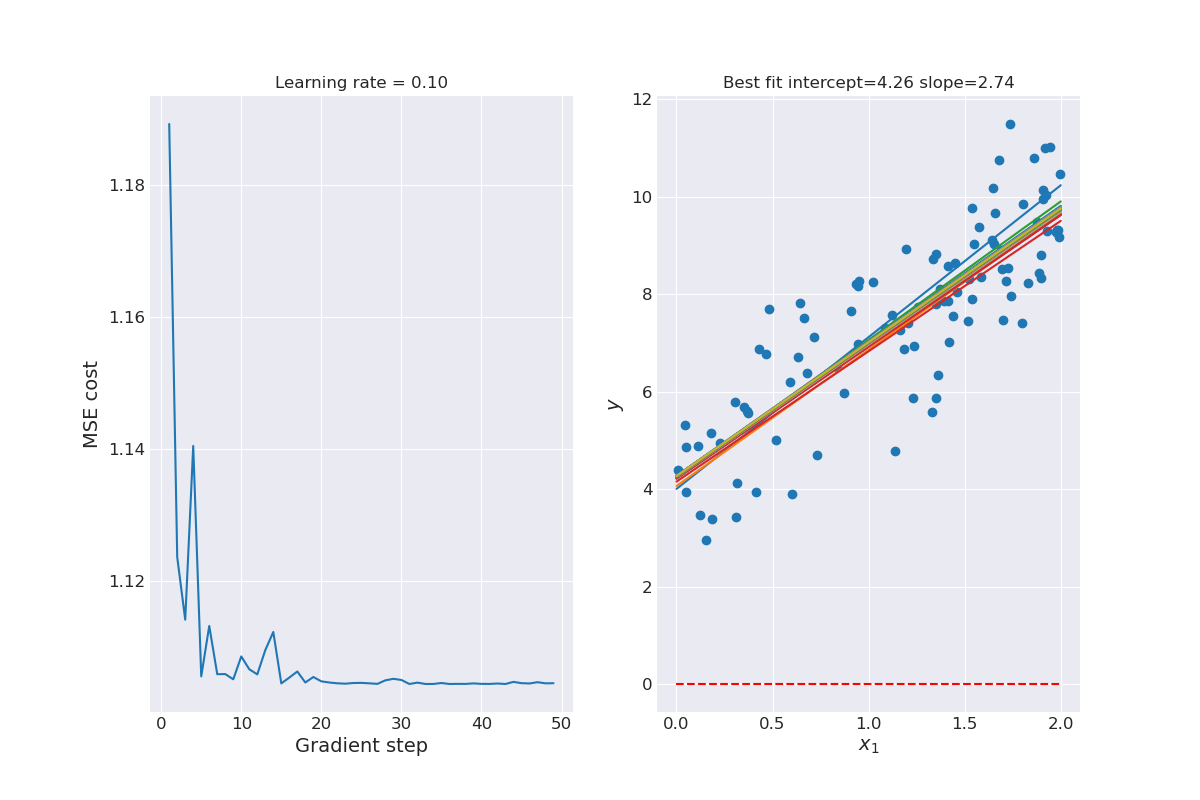

In [55]:
# visualize the resulting gradient descent
steps = np.arange(num_epochs)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(steps[1:], cost_history[1:]) # omit first epoch so can see cost better
plt.xlabel('Gradient step')
plt.ylabel('MSE cost');
title='Learning rate = %0.2f' % learning_rate
plt.title(title);

plt.subplot(1,2,2)
plt.scatter(x, y);
theta_0, theta_1 = Theta_history[0]
x_h = np.linspace(0, 2, 2)
y_h = theta_0 + theta_1 * x_h
plt.plot(x_h, y_h, 'r--') # plot initial starting/random as red dashed line
for (theta_0, theta_1) in Theta_history[1:]:
    y_h = theta_0 + theta_1 * x_h
    plt.plot(x_h, y_h)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$y$')
title = 'Best fit intercept=%0.2f slope=%0.2f' % (Theta[0], Theta[1])
plt.title(title);

By default, as our text discussed briefly, the `LinearRegressor` object of
`Scikit-learn` actually uses an exact method based on singular value
decomposition.  However, if you have truly big data but still want to
use `Scikit-learn`, you can use an SGD iterative algorithm to fit a linear
regrsssion using the `SGDRegressior` estimator object from the sklearn
library.

The `SGDRegressor` defaults to optimizing the squared error cost function,
but as you would imagine has much more sophisticated learning schedules
and algorithm parameters.  To use the sklearn object for SGD regression,
we can do the following.  Here the code runs for a maximum of 1000 epochs
(more than we have been doing by hand in previous 2 examples).  There is
an early stopping condition, if the loss drops by less than
$.001$ (`1e-3`) during an epoch we will stop.  There is a built in learning
rate schedule, but we specify that we start with a learning rate of $0.1$,
which is similar to what our own defined learning schedule function does.
No regularization is used (`penalty=None`), we will discuss regularization
in a bit.

In [56]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(x, y.ravel()) # notice, we use x, without the bias terms added in

SGDRegressor(eta0=0.1, penalty=None)

In [57]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.13652377]), array([2.66063561]))

In [58]:
sgd_reg.n_iter_

10

### Mini-batch Gradient Descent

The last gradient descent algorithm we will look at is called
**mini-batch gradient descent**.  It is simple to understand once you
have looked at batch and stochastic gradient descent.  Mini-batch
is a compromise between the two.  Instead of only looking at 1
sample (stochastic) or the whole batch of samples, we will instead
select a small batch of samples of size $N$ at random, calculate gradients
for this batch, and perform an update step based on these gradients.
The size of a mini-batch is a hyperparameter of this variant of
gradient descent.  Because it is a batch of samples, the loss and
progress will tend to be smoother than pure stochastic gradient descent,
but will of course have some variation, so not as smooth as full batch
gradient descent.  But you can make batches relatively big, but still much
smaller than what your in-core memory can handle.  So mini-batch like
stochastic descent can be used for huge data sets, where you need to
load batches into memory at a time.  It is generally a good
compromise, which will make for smoother progress than only 1 sample
at a time, while still retaining the benefits of stochastic sampling.

As a final variation, we can add a hyperparameter `batch_size` to our
previous implementation, and use the idea of random shuffled
indexes like our previous version to feed in mini-batches we 
slice off in `batch_size` chunks.

In [59]:
def minibatch_gradient_descent(X, y, num_epochs=1000, batch_size=10):
    """This function performs mini-batch gradient descent.  In this third
    version we sample randomly from the samples, like stochastic descent.
    But we sample batch_size items for each update.  We perform the
    indicated number of epochs iterations.
    During each epoch we iterate m times, where m is the number of samples
    in the training data X.  Theta is initialized to 0's initially by this
    function, and the minimal Theta achieved is returned, along with a hisory
    of the Theta values that were stepped through.  We are given the input
    samples X and the correct labels y we are to optimize for.
    
    Parameters
    ----------
    X - A NumPy array of input values to fit a linear model to using MSE cost
        function.  The array should be of size (m, n) where m = number of sample
        rows and n = number of feature columns
    y - A NumPy array of values that are the true lables or targets that we
        are fitting our linear function to.  Expected to be a vector of
        size (m,)
    num_epochs - Number of gradient descent epochs to perform.  Within each
        epoch we perform m iterations, where m is the number of samples in the
        input training set X.
        
    Returns
    -------
    Theta - Returns the final best fit Theta parameter vectors
    history - A history of the Theta and gradients, returned as list of
        tuples (Theta, cost)
    """
    # get the number of samples m and number of features n
    m, n = X.shape
    
    # create random / 0 initial starting point for Theta
    Theta = np.zeros( (n, 1) )
    
    # keep and return history of gradient descent
    history = []
    
    # iterate down the gradient
    for epoch in range(num_epochs):
        # randomly sample an item m times for each epoch, using the randoly selected
        # item to perform a gradient step
        
        # we will keep history before start of each epoch
        cost = cost_function_MSE(Theta, X, y)
        
        # keep track of history of our gradient descent
        history.append( (Theta, cost) )
        #print('Epoch %d: cost: %0.4f' % (epoch, cost[0]))
        #print('    Theta: ')
        #print(Theta)

        # create a randomly shuffled index schedule to use for this epoch
        random_indexes = list(range(m))
        np.random.shuffle(random_indexes) # shuffled in place
        bi = 0
        ei = batch_size
        iter = 0
        while bi < m:
            # select a batch using the random_index shuffled list of index.  We
            # get out a list of integers we use as an index mask into the X and y arrays
            idx_mask = random_indexes[bi : ei]
            xi = X[idx_mask]
            yi = y[idx_mask]
            
            # calculate current cost and the gradients w/respect to our current parameters
            gradients = gradient_function_MSE(Theta, xi, yi)
            
            # calculate learning rate using schedule
            eta = learning_schedule(epoch * m + iter * batch_size)
            
            # update 1 gradient descent step down the gradient according to the learning rate
            Theta = Theta - (eta * gradients)
        
            # update batch indexes for next iteration
            bi += batch_size
            ei += batch_size
            iter += batch_size
            if ei > m:
                ei = m
        
    # return the final result
    return Theta, history

In [60]:
num_epochs = 50
batch_size = 5
Theta, history = minibatch_gradient_descent(X, y, num_epochs=num_epochs, batch_size=batch_size)
print('Theta best fit: ')
print(Theta)

Theta best fit: 
[[3.62206432]
 [3.20917968]]


In [61]:
Theta_history = [h[0] for h in history]
cost_history = [h[1] for h in history]

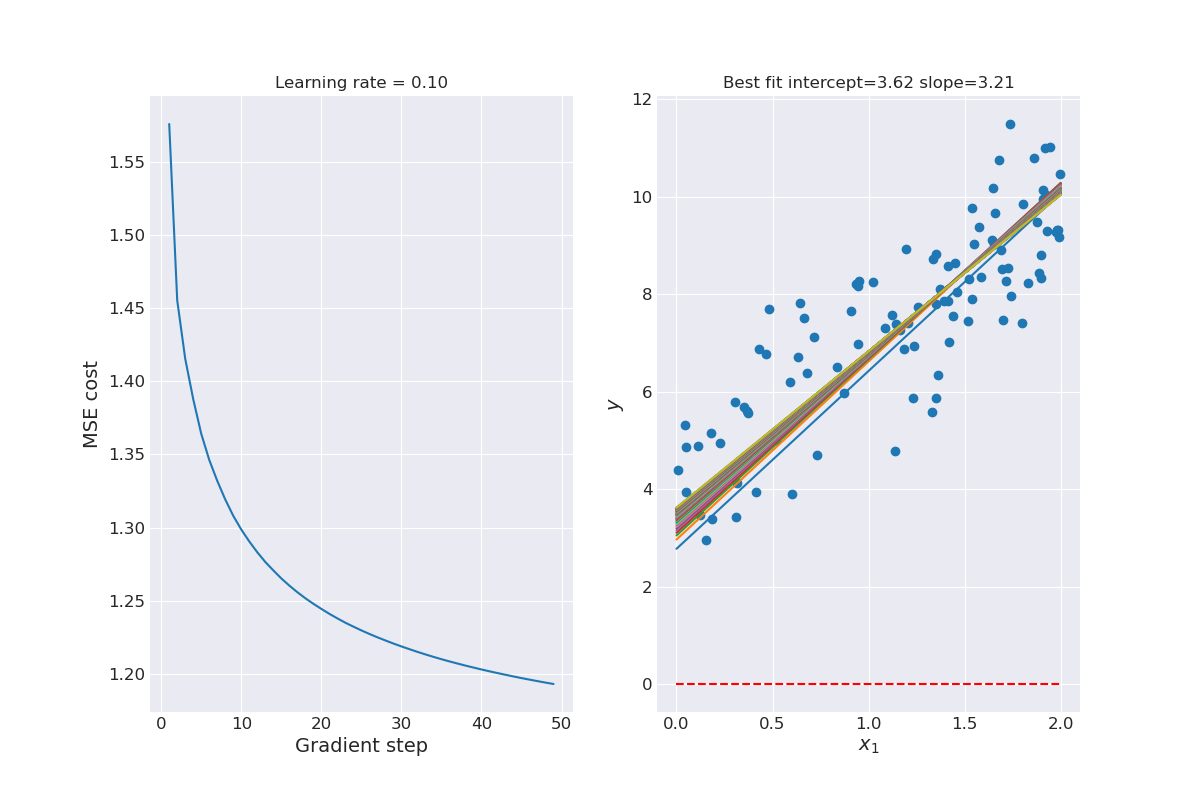

In [62]:
# visualize the resulting gradient descent
steps = np.arange(num_epochs)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(steps[1:], cost_history[1:]) # omit first epoch so can see cost better
plt.xlabel('Gradient step')
plt.ylabel('MSE cost');
title='Learning rate = %0.2f' % learning_rate
plt.title(title);

plt.subplot(1,2,2)
plt.scatter(x, y);
theta_0, theta_1 = Theta_history[0]
x_h = np.linspace(0, 2, 2)
y_h = theta_0 + theta_1 * x_h
plt.plot(x_h, y_h, 'r--') # plot initial starting/random as red dashed line
for (theta_0, theta_1) in Theta_history[1:]:
    y_h = theta_0 + theta_1 * x_h
    plt.plot(x_h, y_h)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$y$')
title = 'Best fit intercept=%0.2f slope=%0.2f' % (Theta[0], Theta[1])
plt.title(title);